In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from hydra import initialize, compose
import pickle
from glob import glob
from astropy.visualization import make_lupton_rgb

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='../../config'):  # ../../
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.plots import diagnostic_plot, plot, plot_util, overplot

In [3]:
input_parent_dir = config.machine.dir_04
sca_dirnames = [os.path.basename(d) for d in glob(os.path.join(input_parent_dir, 'sca*')) if os.path.isdir(d)]
scas = sorted([int(d[3:]) for d in sca_dirnames])
scas = [str(sca).zfill(2) for sca in scas]

uid_dict = {}
for sca in scas:
    pickled_lenses = sorted(glob(config.machine.dir_04 + f'/sca{sca}/galsim_*.npy'))
    lens_uids = [os.path.basename(i).split('_')[1] for i in pickled_lenses]
    lens_uids = list(set(lens_uids))  # remove duplicates
    lens_uids = sorted(lens_uids)
    uid_dict[sca] = lens_uids

In [4]:
def _rescale_rgb_float(image_b, image_g, image_r):
    max = plot_util.get_v([image_b, image_g, image_r])
    image_b /= max
    image_g /= max
    image_r /= max

    return image_b, image_g, image_r

def get_rgb(image_b, image_g, image_r, minimum=None, stretch=3, Q=4):
    # image_b, image_g, image_r = _rescale_rgb_float(image_b, image_g, image_r)

    # assert image_b.shape == image_g.shape == image_r.shape
    if minimum is None:
        min_r = np.min(image_r)
        min_g = np.min(image_g)
        min_b = np.min(image_b)
        # minimum = np.min(np.concatenate((image_b, image_g, image_r)))
        minimum = [min_r, min_g, min_b]
        # print(minimum)
    return make_lupton_rgb(image_r=image_r, image_g=image_g, image_b=image_b, minimum=minimum, stretch=stretch, Q=Q)

In [17]:
color_images = []

for sca in scas:
    uid_list = uid_dict[sca]
    for uid in uid_list:
        # print(f'uid: {uid}')
        f106 = np.load(input_parent_dir + f'/sca{str(sca).zfill(2)}/galsim_{uid}_F106.npy')
        f129 = np.load(input_parent_dir + f'/sca{str(sca).zfill(2)}/galsim_{uid}_F129.npy')
        f184 = np.load(input_parent_dir + f'/sca{str(sca).zfill(2)}/galsim_{uid}_F184.npy')

        rgb_image = get_rgb(image_b=f106, image_g=f129, image_r=f184, stretch=2, Q=3, minimum=None)
        color_images.append(rgb_image)
        # print('\n')

In [18]:
vargs = plot_util.set_v(color_images)
print(vargs)

{'vmin': 1, 'vmax': 255}


In [19]:
dark = color_images[0]
light = color_images[6]

print(f'dark: min {np.min(dark)}, max {np.max(dark)}')
print(f'light: min {np.min(light)}, max {np.max(light)}')

dark: min 0, max 133
light: min 0, max 223


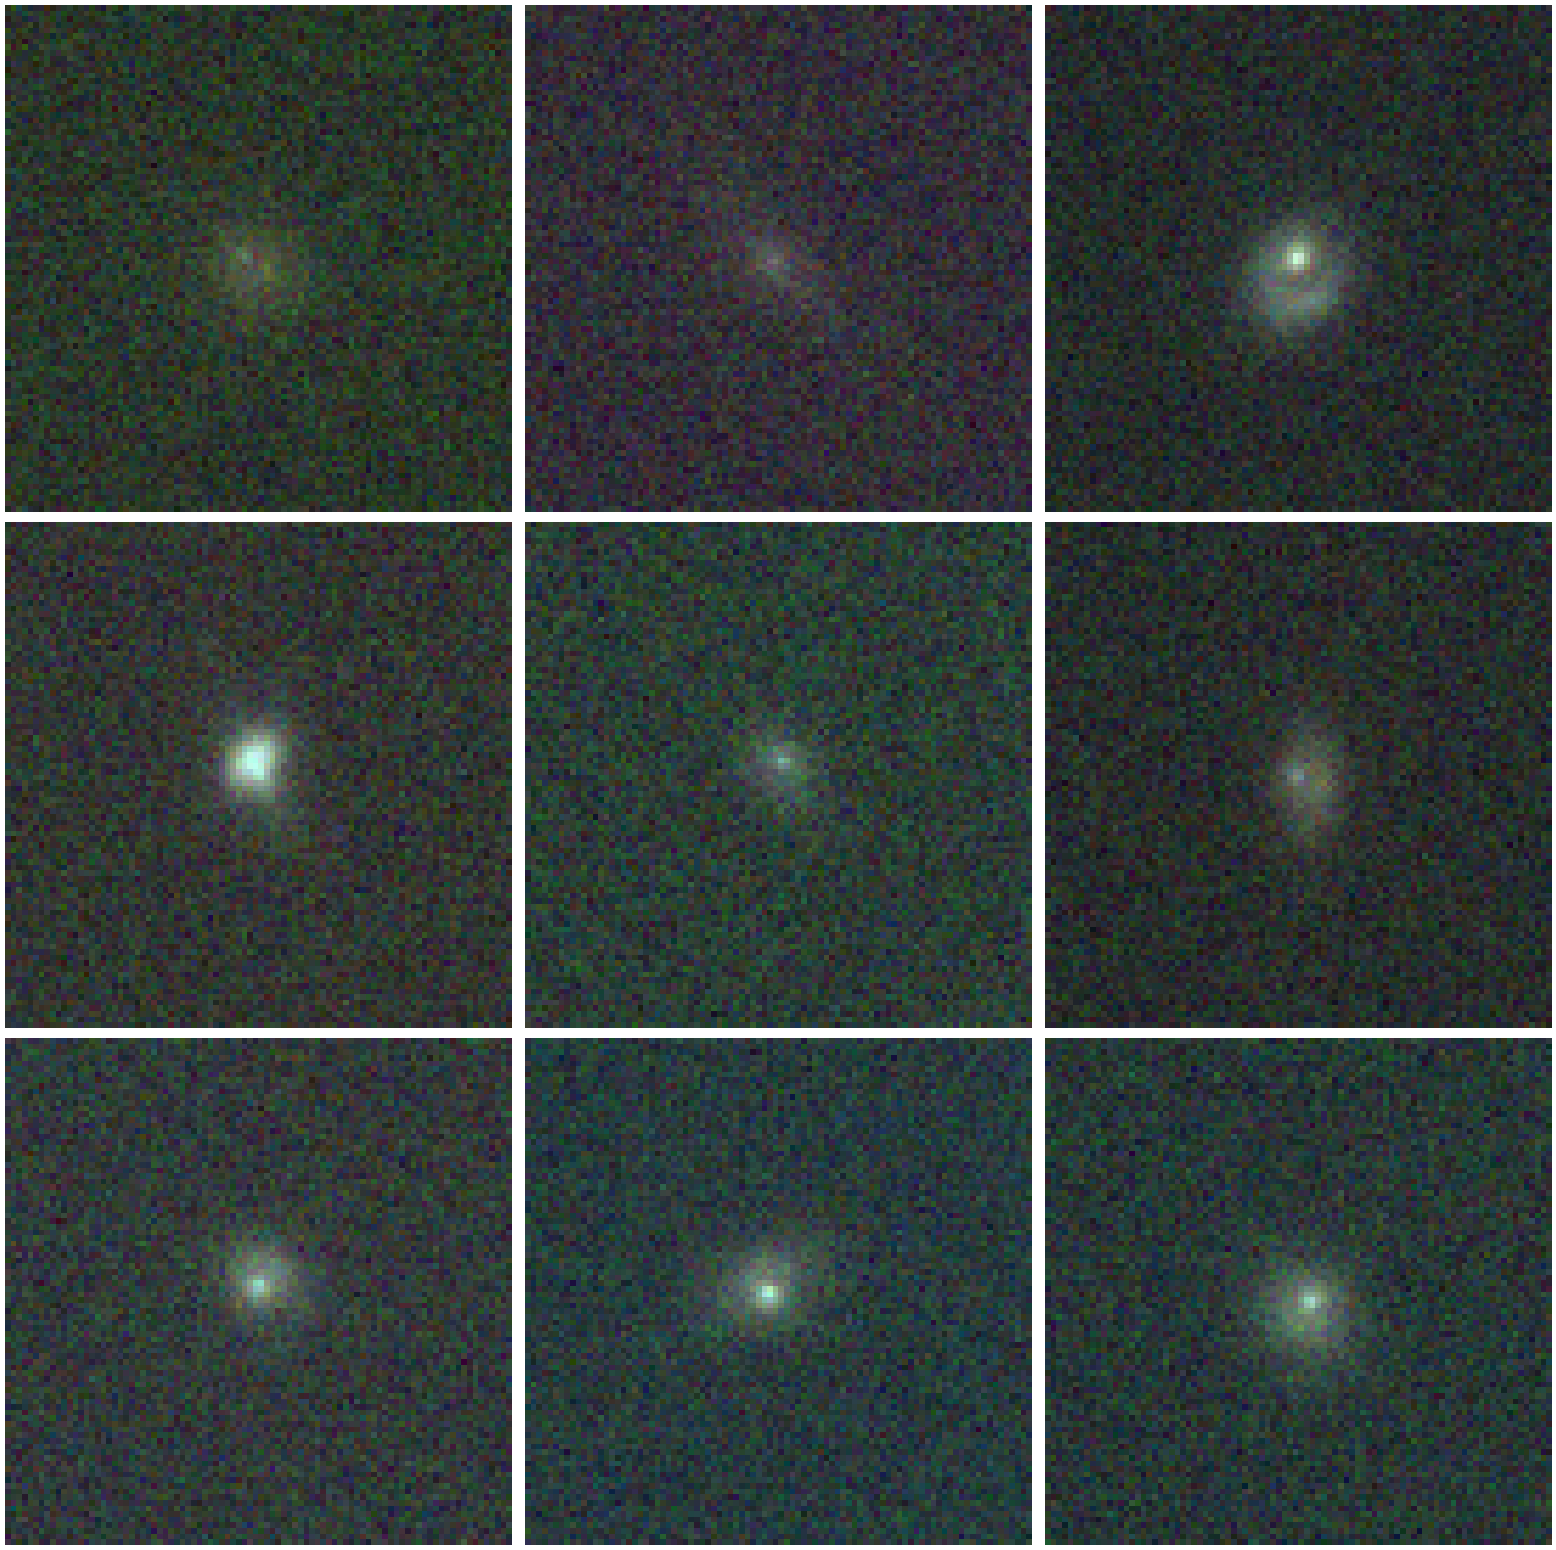

In [20]:
plot.rgb_plot_grid(color_images, 3)